~~~
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~
# Quick start with Hugging Face

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/derm-foundation/blob/master/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>  
  <td style="text-align: center">
    <a href="https://github.com/google-health/derm-foundation/blob/master/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/derm-foundation">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This Colab notebook provides a basic usage example of the Derm Foundation encoder that generates a machine learning representation of images, known as "embeddings", from dermatological images. These embeddings can be used to develop custom machine learning models for dermatology use-cases with less data and compute compared to traditional model development methods.

 Learn more about embeddings and their benefits at [this page](https://developers.google.com/health-ai-developer-foundations/derm-foundation).

In [2]:
# @title Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

# Authenticate user for HuggingFace if needed. Enter token below if requested.
#login เข้า Hugging face เพราะจะโหลด โมเดลมาที่เป็น private ต้องใช้ token
from huggingface_hub.utils import HfFolder
from huggingface_hub import notebook_login

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


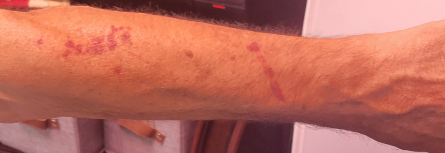

In [3]:
# @title Load and display test image from SCIN Dataset
# https://github.com/google-research-datasets/scin

from PIL import Image
from io import BytesIO
from IPython.display import Image as IPImage, display

# Download sample image
!wget -nc -q https://storage.googleapis.com/dx-scin-public-data/dataset/images/3445096909671059178.png

# Load the image, process, and directly display it
img = Image.open("3445096909671059178.png")
buf = BytesIO()
img.convert('RGB').save(buf, 'PNG')
image_bytes = buf.getvalue()
display(IPImage(data=buf.getvalue()))

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

variables.index:   0%|          | 0.00/5.61k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

scin_dataset_precomputed_embeddings.npz:   0%|          | 0.00/514M [00:00<?, ?B/s]

variables/variables.data-00000-of-00001:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

Size of embedding vector: 6144


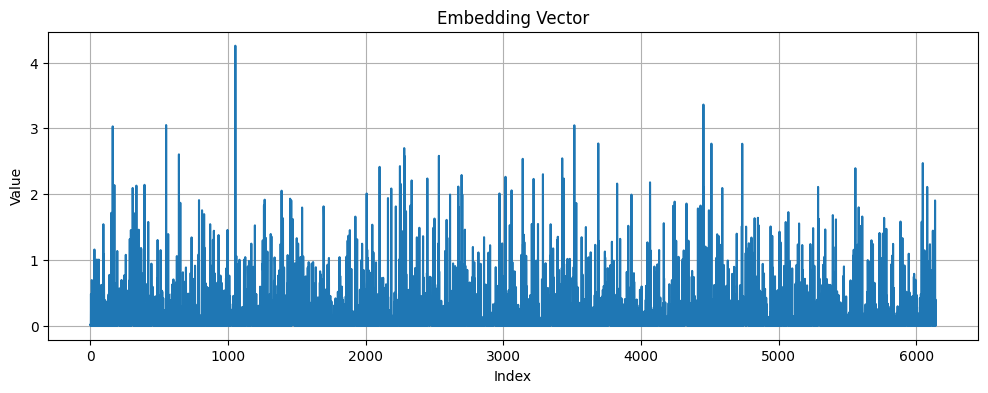

In [4]:
# @title Compute Embeddings
from huggingface_hub import from_pretrained_keras
import tensorflow as tf
import matplotlib.pyplot as plt

# Format input
input_tensor= tf.train.Example(features=tf.train.Features(
        feature={'image/encoded': tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image_bytes]))
        })).SerializeToString()

# Load the model directly from Hugging Face Hub
loaded_model = from_pretrained_keras("google/derm-foundation")

# Call inference
infer = loaded_model.signatures["serving_default"]
output = infer(inputs=tf.constant([input_tensor]))

# Extract the embedding vector
embedding_vector = output['embedding'].numpy().flatten()
print("Size of embedding vector:", len(embedding_vector))

# Plot the embedding vector
plt.figure(figsize=(12, 4))
plt.plot(embedding_vector)
plt.title('Embedding Vector')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# #กราฟตรงนี้ ไม่ได้ให้ข้อมูลเชิงมนุษย์อ่านตรง ๆ เช่น “นี่คือมะเร็ง”
# แต่มันช่วยยืนยันว่าเราได้ embedding จริง ๆ จากโมเดล
# การนำไปใช้จริงคือ:
# นำ embedding นี้ไป เปรียบเทียบกับ embedding อื่น (เช่น cosine similarity) → หาว่ารูปนี้คล้ายกับโรคใด
# หรือใช้เป็น feature vector สำหรับ train classifier ต่อ (เช่น logistic regression, neural net ชั้นเล็ก ๆ)

### **เอาไปประยุกย์ใช้**

### **1.Read/Open Image**

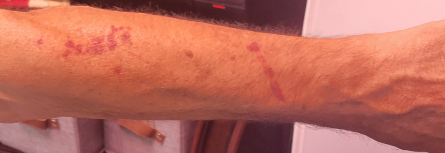

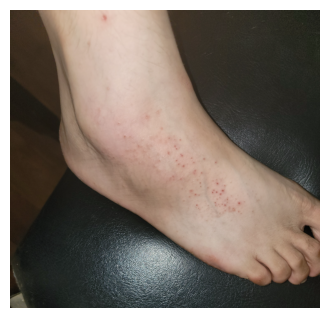

In [9]:
from PIL import Image
import requests
from io import BytesIO

# โหลดภาพจาก SCIN dataset
url1 = "https://storage.googleapis.com/dx-scin-public-data/dataset/images/3445096909671059178.png"
url2 = "/content/d1.png"

img1 = Image.open(BytesIO(requests.get(url1).content)).convert("RGB")
img2 = Image.open(url2).convert("RGB")

display(img1, img2)

### **2.แปลงภาพเป็น embeding**

In [10]:
import tensorflow as tf
from huggingface_hub import from_pretrained_keras

# โหลดโมเดล Derm Foundation
model = from_pretrained_keras("google/derm-foundation")
infer = model.signatures["serving_default"]

def get_embedding(image):
    buf = BytesIO()
    image.save(buf, format="PNG")
    image_bytes = buf.getvalue()

    input_tensor = tf.train.Example(
        features=tf.train.Features(
            feature={'image/encoded': tf.train.Feature(
                bytes_list=tf.train.BytesList(value=[image_bytes]))
            }
        )
    ).SerializeToString()

    output = infer(inputs=tf.constant([input_tensor]))
    return output['embedding'].numpy().flatten()

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

### **3.คำนวณ similarity ระหว่างภาพ**

In [11]:
import numpy as np

# สร้าง embedding ของทั้งสองภาพ
vec1 = get_embedding(img1)
vec2 = get_embedding(img2)

# cosine similarity
cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

print("Cosine similarity between two images:", cos_sim)


Cosine similarity between two images: 0.4298694


# Next steps

Explore the other [notebooks](https://github.com/google-health/derm-foundation/blob/master/notebooks) to learn what else you can do with the model.